Load and prepare the required data:

In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# since we use multiple workers, we set this env variable
import os
os.environ['TOKENIZERS_PARALLELISM']="true"

In [ ]:
import torch
assert torch.cuda.is_available(), "Oho, no GPU available..."

In [ ]:
chosen_language_code = "de" # Full name of language here

In [ ]:
from datasets import load_dataset

# Download the data
dataset = load_dataset('polyglot_ner', chosen_language_code)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

polyglot_ner.py:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

The repository for polyglot_ner contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/polyglot_ner.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/547578 [00:00<?, ? examples/s]

In [ ]:
# Check what kind of splits exist
dataset.keys()

dict_keys(['train'])

In [ ]:
# Check the dataset length
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'lang', 'words', 'ner'],
        num_rows: 547578
    })
})


In [ ]:
# Load the datasets
train_set1000 = load_dataset('polyglot_ner', chosen_language_code, split="train[0:1000]")
train_set3000 = load_dataset('polyglot_ner', chosen_language_code, split="train[0:3000]")
test_set = load_dataset('polyglot_ner', chosen_language_code, split="train[3000:5000]")

# Print some statistics
print(train_set1000)
print(train_set3000)
print(test_set)

Dataset({
    features: ['id', 'lang', 'words', 'ner'],
    num_rows: 1000
})
Dataset({
    features: ['id', 'lang', 'words', 'ner'],
    num_rows: 3000
})
Dataset({
    features: ['id', 'lang', 'words', 'ner'],
    num_rows: 2000
})


Note: The dataset of polyglot_ner for this language must contain atleast 7000 samples. Please ensure before the language you work with.

### TODO: Inspect and Describe the Data, including Average and Maximum Input length (in tokens)

📝❓Why do you need to be aware of the longest input length within your dataset? Which parameter of the model dictates this?

<font color='blue'>
There are two reasons for that.
</font>

1. <font color='blue'>Some models have a maximum sequence length (e.g. Bert has 512 tokens). If the input is longer, the model needs to truncate (or to pad it is shorter). The parameter max_sequence_length indicates this.</font>

2. <font color='blue'>The input length also affects the memory usage and training time. Longer sequences require more memory since the attention mechanism in BERT scales quadratically with the sequence length.</font>



In [ ]:
# since, the labels miss the "B-"" (at the beginning of an entity) and the "I-" (in an entity but not at the beginning) we can prepend those label-parts.
def iob_ify_labels(item):
    """Turn iob-like labels into true iob.

    Assumes that all same labels without interruption belong to the same entity.

    Args:
        item: single example of datasets.Dataset
    Returns:
        The modified labels (list of str)
    """
    labels = item['ner']
    new_labels = []
    prev_label = 'O'
    for label in labels:
        if label == 'O':
            new_labels.append('O')
            prev_label = 'O'
        else:
            if prev_label == 'O':
                new_labels.append('B-' + label)
            else:
                new_labels.append('I-' + label)
            prev_label = label
    return {'ner': new_labels}

# test:
test_labels = {'ner': ['O', 'PER', 'PER', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'LOC', 'LOC', 'LOC', 'O']}
print(iob_ify_labels(test_labels)['ner'])

['O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']


In [ ]:
max_sequence_length = 256   # ? maximum subtoken length. You should use this later

<font color='blue'>
We now map the labels of the dataset to the new labels
</font>

In [ ]:
# map ner-tags to labels

train_set1000 = train_set1000.map(iob_ify_labels)
train_set3000 = train_set3000.map(iob_ify_labels)
test_set = test_set.map(iob_ify_labels)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<font color='blue'>
Define a map to map label (strings) to label_ids (int)
</font>

In [ ]:
def create_label_map(dataset):
  """create a mapping from NER labels to integers."""
  unique_labels = set()
  for example in dataset['ner']:
    unique_labels.update(example)
  label_map = {label : i for i, label in enumerate(sorted(unique_labels))}
  return label_map

In [ ]:
# Create label mapping
label_map = create_label_map(train_set3000)

### TODO: Map the NER-tags from their string representation to numerical labels.

In [ ]:
from transformers import AutoTokenizer
import torch

#load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<font color='blue'>
Below, we tokenize the data.
</font>
<br>
<br>
<font color='blue'>
The function uses a Hugging Face tokenizer to convert the text data (i.e., sequences of words) into token IDs. It handles word splitting, padding, and truncation based on the specified maximum sequence length
</font>
<br>
<br>
<font color='blue'>
For NER tasks, each word in the input text has a corresponding NER label. Since tokenization may split a word into multiple subwords, the function aligns the NER labels with the tokenized output.
The `tokenize_and_align_labels` helper function assigns NER labels to the first subtoken of a word and sets the labels of subsequent subtokens to `-100` (which is ignored during model training). This helps maintain the correct alignment between the original labels and the tokenized input.

</font>

In [ ]:
def encode_dataset(dataset, tokenizer, max_sequence_length):
    """Encode the input dadaset using a huggingface-tokenizer.

    Args:
        dataset: datasets.Dataset
    Returns:
        The encoded dataset (list of dicts) and lengths (list of ints)
        containing the number of subtokens of each example.
    """
    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(
            examples['words'],
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=max_sequence_length,
            return_tensors='pt'
        )

        labels = []
        for i, label_sequence in enumerate(examples['ner']):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []

            for word_idx in word_ids:
                # Special tokens have word_idx set to None
                if word_idx is None:
                    label_ids.append(-100)
                # For the first token of a word, convert string label to integer
                elif word_idx != previous_word_idx:
                    label_ids.append(label_map[label_sequence[word_idx]])
                # For subsequent subtokens of a word, use -100
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx

            labels.append(label_ids)

        tokenized_inputs['labels'] = labels

        return tokenized_inputs

    # Apply the tokenization to the dataset
    encoded_dataset = dataset.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=dataset.column_names,
    )

    # Calculate the actual lengths of each sequence
    input_lengths = [max_sequence_length] * len(encoded_dataset)

    return encoded_dataset, input_lengths

In [ ]:
# encode the two training sets and the test set

# Encode the training sets
encoded_train_set1000, length_encoded_train_set1000 = encode_dataset(train_set1000, tokenizer, max_sequence_length)
encoded_train_set3000, length_encoded_train_set3000 = encode_dataset(train_set3000, tokenizer, max_sequence_length)

# Encode the test set
encoded_test_set, length_encoded_test_set = encode_dataset(test_set, tokenizer, max_sequence_length)

# Change the format
encoded_train_set1000.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])
encoded_train_set3000.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])
encoded_test_set.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# check out how the training sets are encoded
for key, val in encoded_train_set1000[0].items():
    print(f'{key}: {val.size()}')

input_ids: torch.Size([256])
token_type_ids: torch.Size([256])
attention_mask: torch.Size([256])
labels: torch.Size([256])


Example of how your output could look like.

input_ids: torch.Size([???])

token_type_ids: torch.Size([???])

attention_mask: torch.Size([???])

labels: torch.Size([???])

📝❓What value should replace the three question marks in your print? Should this be the same for all samples? Why/Why not?

<font color='blue'> The value 256 replaces the question marks in our example because we defined max_sequence_length = 256 beforehand. By using padding and truncation during tokenization, we make sure that every input sequence is either padded or truncated to exactly 256 tokens. This consistency in sequence length is important for batch processing, so each sample has the same shape.

In [ ]:
# from transformers import What are the three imports from transformers we need? Hint: Look at the tutorial notebook.
import os
os.environ["WANDB_MODE"] = "disabled"

### TODO: Initialise your model and set up your training arguments

📝❓When initializing the BertForTokenClassification-class with BERT-base you should get a warning message. Explain why you get this message.

<font color=blue>The reason why the warning appears is that BERT was not initially tranined for the token classification tasks. Only the "base-model" is trained, and we append a fully-connected classification layer at the end (to map the output to the number of labels according to our task). The warning says that this last layer has not been trained. Thus, we need to adjust and optimize the weights so that our model has a better performance.

In [ ]:
from transformers import (
    BertForTokenClassification,
    TrainingArguments,
    Trainer,
)

model = BertForTokenClassification.from_pretrained(
        'bert-base-cased',
        num_labels=len(label_map)
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
del model # removes it from memory so you can load another instance of the model.



### TODO Train your Model ⚡ GPU 2-3 mins

Suggested: 4 Epochs with training batch size of 16/32/64 - Depends on the available GPU memory after loading the model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    """
    Compute metrics for NER evaluation including micro and macro F1 scores.

    Args:
        pred: Prediction object containing predictions and label_ids

    Returns:
        Dictionary containing accuracy, micro and macro averaged metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Remove ignored index (special tokens)
    true_predictions = [
        p for (p, l) in zip(preds.flatten(), labels.flatten())
        if l != -100
    ]
    true_labels = [
        l for (p, l) in zip(preds.flatten(), labels.flatten())
        if l != -100
    ]

    # Calculate micro averaged metrics
    micro_results = precision_recall_fscore_support(
        true_labels,
        true_predictions,
        average='micro',
        zero_division=0
    )

    # Calculate macro averaged metrics
    macro_results = precision_recall_fscore_support(
        true_labels,
        true_predictions,
        average='macro',
        zero_division=0
    )

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        'accuracy': accuracy,
        'micro_precision': micro_results[0],
        'micro_recall': micro_results[1],
        'micro_f1': micro_results[2],
        'macro_precision': macro_results[0],
        'macro_recall': macro_results[1],
        'macro_f1': macro_results[2]
    }

In [ ]:
from datasets import Dataset

def train_model(
    run_name: str,
    train_dataset: Dataset,
    eval_dataset: Dataset = encoded_test_set,
    freeze_embeddings: bool = False,
):

  # Create a new model instance berfore training
  model = BertForTokenClassification.from_pretrained(
        'bert-base-cased',
        num_labels=len(label_map)
  )

  # Optionally freeze the embeddings
  if freeze_embeddings:
      for param in model.bert.embeddings.parameters():
          param.requires_grad = False

  # Define the training parameters
  training_args = TrainingArguments(
          output_dir=f"{run_name}/",
          num_train_epochs=10,
          per_device_train_batch_size=64,
          per_device_eval_batch_size=64,
          learning_rate=2e-5,
          weight_decay=0.01,
          eval_strategy="epoch",
          save_strategy="epoch",
          logging_dir=f"{run_name}/logs",
          logging_steps=1,
          load_best_model_at_end=True,
          metric_for_best_model="micro_f1",
          greater_is_better=True,
          save_total_limit=1,
          fp16=True,
          dataloader_num_workers=2,
      )

  # Setup the trainer instance
  trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          compute_metrics=compute_metrics,
  )

  # Train the model
  trainer.train()

  # Evaluate the model
  eval_results = trainer.evaluate()

  # Print the results
  print("\nEvaluation Results:")
  for key, value in eval_results.items():
      print(f"{key}: {value:.4f}")

  # Save the final model
  trainer.save_model()

  # cleanup
  del model
  del trainer
  del training_args

  return eval_results

In [ ]:
eval_results_small_not_frozen = train_model("small_not_frozen", encoded_train_set1000, freeze_embeddings=False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1
1,0.132100,0.342196,0.936825,0.936825,0.936825,0.936825,0.133832,0.142857,0.138197
2,0.173800,0.253743,0.936825,0.936825,0.936825,0.936825,0.133832,0.142857,0.138197
3,0.171500,0.217855,0.937244,0.937244,0.937244,0.937244,0.388433,0.150272,0.152188
4,0.205900,0.197548,0.941487,0.941487,0.941487,0.941487,0.621110,0.301729,0.349420
5,0.129500,0.187955,0.944697,0.944697,0.944697,0.944697,0.631235,0.365039,0.425588
6,0.100500,0.182553,0.944613,0.944613,0.944613,0.944613,0.603135,0.441196,0.488257
7,0.115000,0.183595,0.942129,0.942129,0.942129,0.942129,0.569932,0.504840,0.523002
8,0.105900,0.185274,0.944502,0.944502,0.944502,0.944502,0.589919,0.506553,0.532113
9,0.064000,0.187716,0.943078,0.943078,0.943078,0.943078,0.568293,0.527094,0.537611
10,0.111900,0.188021,0.944809,0.944809,0.944809,0.944809,0.584868,0.518237,0.539974



Evaluation Results:
eval_loss: 0.1880
eval_accuracy: 0.9448
eval_micro_precision: 0.9448
eval_micro_recall: 0.9448
eval_micro_f1: 0.9448
eval_macro_precision: 0.5849
eval_macro_recall: 0.5182
eval_macro_f1: 0.5400
eval_runtime: 7.4467
eval_samples_per_second: 268.5770
eval_steps_per_second: 4.2970
epoch: 10.0000


### TODO: Compute Metrics/Performance (Macro and Micro F1) of your model.

📝❓ Is there a challenge when evaluating the predictions of your model? Why is this challenge present and how do you plan to deal with it?

Hint: Look at the predictions lengths and distributions of labels

<font color='blue'> The most prominent challenge is the label distribution. As our plot at the very end of this notebook shows, the `O` label is occurs the most. We decided not to weight the loss accordingly, even though that could be a good measure for this issue. Instead, we report micro and macro metrics. Micro metrics aggregate contributions from all classes, giving a better picture of overall performance, especially when the dataset has a dominant class.
Macro metrics calculate the metric for each class independently and then average them, ensuring that the performance on minority classes is not overlooked.</font>

<font color='blue'>The other issue is the sequence length and the tokenization that might split a word into subwords; We deal with this by only assigning the label to the first subword. For all the following subwords from the same word, as well as the special token, we use the label -100. This is ignored in the loss function as well as when calculating the metrics.</font>

To avoid rerunning, please also print the metrics of each model that completed training

In [ ]:
print(eval_results_small_not_frozen)

{'eval_loss': 0.1880212277173996, 'eval_accuracy': 0.9448089109740097, 'eval_micro_precision': 0.9448089109740097, 'eval_micro_recall': 0.9448089109740097, 'eval_micro_f1': 0.9448089109740097, 'eval_macro_precision': 0.5848680051793356, 'eval_macro_recall': 0.5182368834877552, 'eval_macro_f1': 0.5399742480765324, 'eval_runtime': 7.4467, 'eval_samples_per_second': 268.577, 'eval_steps_per_second': 4.297, 'epoch': 10.0}


### TODO: Prepare and run the other three variants described ⚡ 2 - 10 minutes each.

In [ ]:
# This run is already done above
# eval_results_small_not_frozen = train_model("small_not_frozen", encoded_train_set1000, freeze_embeddings=False)

In [ ]:
eval_results_small_frozen = train_model("small_frozen", encoded_train_set1000, freeze_embeddings=True)
print(eval_results_small_frozen)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1
1,0.132900,0.335339,0.936825,0.936825,0.936825,0.936825,0.133832,0.142857,0.138197
2,0.173000,0.253564,0.936825,0.936825,0.936825,0.936825,0.133832,0.142857,0.138197
3,0.170100,0.225238,0.937886,0.937886,0.937886,0.937886,0.221700,0.151131,0.153491
4,0.213400,0.205033,0.941291,0.941291,0.941291,0.941291,0.688766,0.236313,0.262512
5,0.144400,0.193340,0.942241,0.942241,0.942241,0.942241,0.601908,0.311035,0.351561
6,0.105600,0.189253,0.944781,0.944781,0.944781,0.944781,0.602043,0.397707,0.450489
7,0.130300,0.185707,0.942129,0.942129,0.942129,0.942129,0.571720,0.468427,0.496114
8,0.112300,0.188542,0.945535,0.945535,0.945535,0.945535,0.601252,0.444815,0.490756
9,0.081300,0.186603,0.944334,0.944334,0.944334,0.944334,0.576719,0.479558,0.509425
10,0.116600,0.187614,0.945283,0.945283,0.945283,0.945283,0.594229,0.474840,0.511718



Evaluation Results:
eval_loss: 0.1885
eval_accuracy: 0.9455
eval_micro_precision: 0.9455
eval_micro_recall: 0.9455
eval_micro_f1: 0.9455
eval_macro_precision: 0.6013
eval_macro_recall: 0.4448
eval_macro_f1: 0.4908
eval_runtime: 7.4766
eval_samples_per_second: 267.5000
eval_steps_per_second: 4.2800
epoch: 10.0000
{'eval_loss': 0.1885422319173813, 'eval_accuracy': 0.9455347421903353, 'eval_micro_precision': 0.9455347421903353, 'eval_micro_recall': 0.9455347421903353, 'eval_micro_f1': 0.9455347421903353, 'eval_macro_precision': 0.6012523067196106, 'eval_macro_recall': 0.44481514775840314, 'eval_macro_f1': 0.49075609329926684, 'eval_runtime': 7.4766, 'eval_samples_per_second': 267.5, 'eval_steps_per_second': 4.28, 'epoch': 10.0}


In [ ]:
eval_results_big_not_frozen = train_model("big_not_frozen", encoded_train_set3000, freeze_embeddings=False)
print(eval_results_big_not_frozen)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1
1,0.258500,0.219835,0.938528,0.938528,0.938528,0.938528,0.213206,0.158988,0.165357
2,0.178400,0.163015,0.947936,0.947936,0.947936,0.947936,0.688112,0.382539,0.460799
3,0.122300,0.149982,0.948829,0.948829,0.948829,0.948829,0.618217,0.545573,0.569199
4,0.077300,0.150222,0.947545,0.947545,0.947545,0.947545,0.592577,0.605770,0.594807
5,0.068100,0.152755,0.951509,0.951509,0.951509,0.951509,0.637374,0.608725,0.620012
6,0.052000,0.155540,0.950253,0.950253,0.950253,0.950253,0.619009,0.623121,0.620317
7,0.067200,0.166064,0.948968,0.948968,0.948968,0.948968,0.618608,0.644588,0.628631
8,0.032700,0.170561,0.952179,0.952179,0.952179,0.952179,0.641326,0.608567,0.622872
9,0.034500,0.172188,0.950867,0.950867,0.950867,0.950867,0.631461,0.627420,0.628213
10,0.037000,0.176095,0.950001,0.950001,0.950001,0.950001,0.622060,0.638486,0.629170



Evaluation Results:
eval_loss: 0.1706
eval_accuracy: 0.9522
eval_micro_precision: 0.9522
eval_micro_recall: 0.9522
eval_micro_f1: 0.9522
eval_macro_precision: 0.6413
eval_macro_recall: 0.6086
eval_macro_f1: 0.6229
eval_runtime: 7.2404
eval_samples_per_second: 276.2290
eval_steps_per_second: 4.4200
epoch: 10.0000
{'eval_loss': 0.1705610603094101, 'eval_accuracy': 0.952178889478239, 'eval_micro_precision': 0.952178889478239, 'eval_micro_recall': 0.952178889478239, 'eval_micro_f1': 0.952178889478239, 'eval_macro_precision': 0.6413260278171625, 'eval_macro_recall': 0.6085671136041274, 'eval_macro_f1': 0.6228722641346238, 'eval_runtime': 7.2404, 'eval_samples_per_second': 276.229, 'eval_steps_per_second': 4.42, 'epoch': 10.0}


In [ ]:
eval_results_big_frozen = train_model("big_frozen", encoded_train_set3000, freeze_embeddings=True)
print(eval_results_big_frozen)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Micro Precision,Micro Recall,Micro F1,Macro Precision,Macro Recall,Macro F1
1,0.258600,0.220001,0.938556,0.938556,0.938556,0.938556,0.212044,0.159521,0.166032
2,0.179500,0.163286,0.947991,0.947991,0.947991,0.947991,0.688453,0.379000,0.457023
3,0.124800,0.150125,0.948968,0.948968,0.948968,0.948968,0.622748,0.544127,0.569006
4,0.080100,0.149818,0.947070,0.947070,0.947070,0.947070,0.590921,0.601639,0.591383
5,0.071100,0.150654,0.951397,0.951397,0.951397,0.951397,0.634267,0.604129,0.615980
6,0.056800,0.152615,0.950755,0.950755,0.950755,0.950755,0.622722,0.620618,0.620582
7,0.071400,0.162100,0.949052,0.949052,0.949052,0.949052,0.618609,0.638836,0.626260
8,0.035700,0.166150,0.952346,0.952346,0.952346,0.952346,0.643129,0.605500,0.621982
9,0.037500,0.166963,0.950895,0.950895,0.950895,0.950895,0.630949,0.623792,0.626376
10,0.041000,0.170579,0.950281,0.950281,0.950281,0.950281,0.623233,0.630262,0.625834



Evaluation Results:
eval_loss: 0.1662
eval_accuracy: 0.9523
eval_micro_precision: 0.9523
eval_micro_recall: 0.9523
eval_micro_f1: 0.9523
eval_macro_precision: 0.6431
eval_macro_recall: 0.6055
eval_macro_f1: 0.6220
eval_runtime: 7.1883
eval_samples_per_second: 278.2290
eval_steps_per_second: 4.4520
epoch: 10.0000
{'eval_loss': 0.1661500483751297, 'eval_accuracy': 0.9523463889896988, 'eval_micro_precision': 0.9523463889896988, 'eval_micro_recall': 0.9523463889896988, 'eval_micro_f1': 0.9523463889896988, 'eval_macro_precision': 0.6431287368426373, 'eval_macro_recall': 0.6055003109057363, 'eval_macro_f1': 0.6219820518631443, 'eval_runtime': 7.1883, 'eval_samples_per_second': 278.229, 'eval_steps_per_second': 4.452, 'epoch': 10.0}


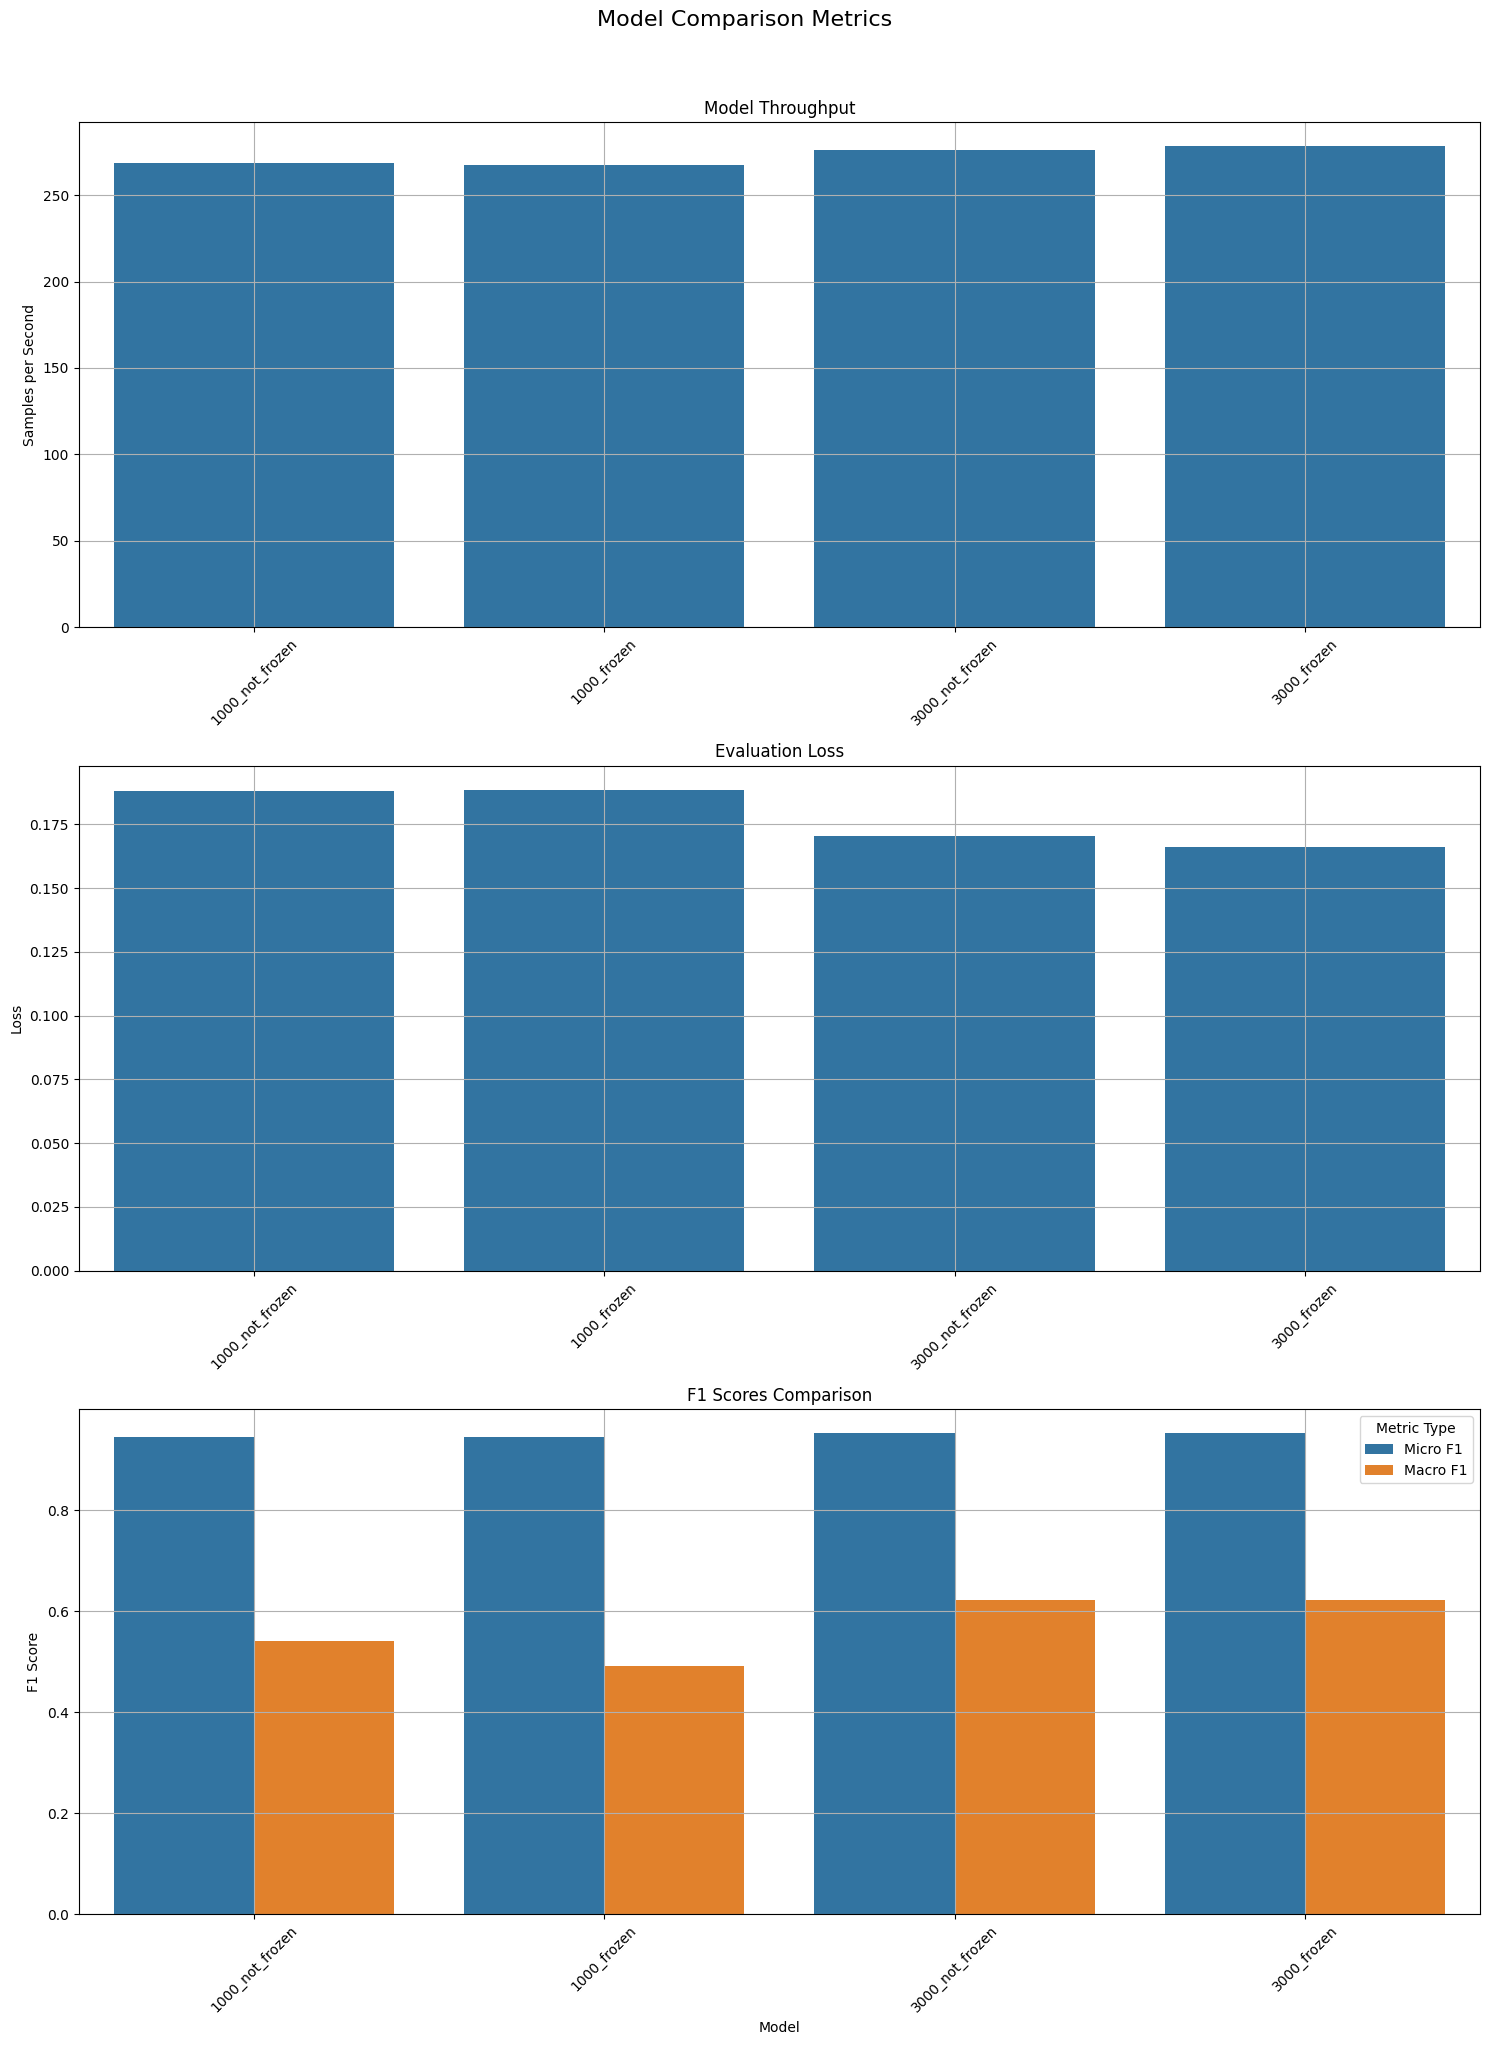

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_comparison_plots(results_dict):
    """
    Create comparison plots for model variants

    Parameters:
    results_dict: Dictionary with keys as model names and values as evaluation results
    """

    # Create figure with subplots - now 2x2 without the radar plot
    fig, axes = plt.subplots(3, 1, figsize=(8, 10))
    fig.suptitle('Model Comparison Metrics', fontsize=14, y=1.02)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Prepare data for plotting
    model_names = list(results_dict.keys())
    metrics = {
        'Throughput (samples/sec)': [r['eval_samples_per_second'] for r in results_dict.values()],
        'Loss': [r['eval_loss'] for r in results_dict.values()],
        'Micro F1': [r['eval_micro_f1'] for r in results_dict.values()],
        'Macro F1': [r['eval_macro_f1'] for r in results_dict.values()],
    }

    # Plot 1: Throughput Comparison (Bar plot)
    sns.barplot(x=model_names, y=metrics['Throughput (samples/sec)'], ax=axes[0])
    axes[0].set_title('Model Throughput')
    axes[0].set_ylabel('Samples per Second')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid()

    # Plot 2: Loss Comparison (Bar plot)
    sns.barplot(x=model_names, y=metrics['Loss'], ax=axes[1])
    axes[1].set_title('Evaluation Loss')
    axes[1].set_ylabel('Loss')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid()

    # Plot 3: F1 Scores Comparison (Grouped bar plot)
    f1_data = pd.DataFrame({
        'Model': model_names * 2,
        'Metric Type': ['Micro F1'] * len(model_names) + ['Macro F1'] * len(model_names),
        'F1 Score': metrics['Micro F1'] + metrics['Macro F1']
    })
    sns.barplot(x='Model', y='F1 Score', hue='Metric Type', data=f1_data, ax=axes[2])
    axes[2].set_title('F1 Scores Comparison')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid()

    # Adjust layout
    plt.tight_layout()
    return fig

# Example usage with your data:
results = {
    '1000_not_frozen': eval_results_small_not_frozen,
    '1000_frozen': eval_results_small_frozen,
    '3000_not_frozen': eval_results_big_not_frozen,
    '3000_frozen': eval_results_big_frozen,
}

# Create plots
fig = create_comparison_plots(results)
plt.show()

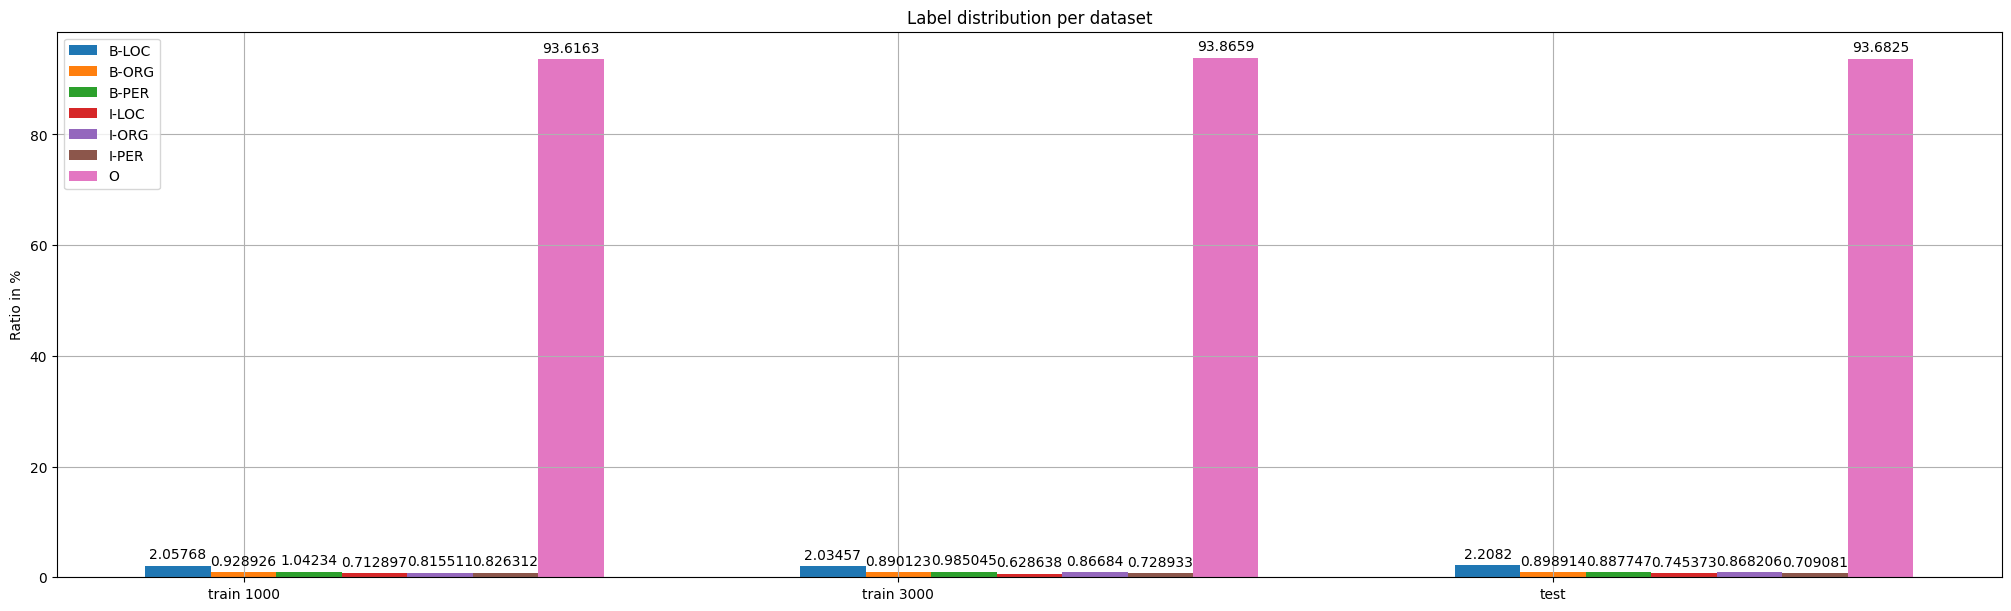

In [ ]:
datasets = {
    'train 1000': encoded_train_set1000,
    'train 3000': encoded_train_set3000,
    'test': encoded_test_set
}
label_map_inverse = {v: k for k, v in label_map.items()}
percentage_matrix = {v: [] for v in label_map.values()}

for dataset in datasets.values():
  # Count the labels
  label_count = {v: 0 for v in label_map.values()}
  for labels in dataset['labels']:
      for label in label_count.keys():
          if label in labels:
              label_count[label] += len(labels[labels == label])

  # calculate the percentage
  total_labels = sum(label_count.values())
  label_percentage = {label: count / total_labels * 100 for label, count in label_count.items()}

  for k,v in label_percentage.items():
    percentage_matrix[k].append(v)

# Plot the data
x = np.arange(len(datasets.keys()))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(20,6))

for attribute, measurement in percentage_matrix.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=label_map_inverse[attribute])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio in %')
ax.set_title('Label distribution per dataset')
ax.set_xticks(x + width, datasets.keys())
ax.grid()
ax.legend()

plt.show()

📝❓Template:

Summary of Performance of the four Model Variants


1. Whole Model finetuning, 1000 samples:
```
Evaluation Results:
eval_loss: 0.1880
eval_accuracy: 0.9448
eval_micro_precision: 0.9448
eval_micro_recall: 0.9448
eval_micro_f1: 0.9448
eval_macro_precision: 0.5849
eval_macro_recall: 0.5182
eval_macro_f1: 0.5400
eval_runtime: 7.4467
eval_samples_per_second: 268.5770
eval_steps_per_second: 4.2970
epoch: 10.0000
```

2. Frozen Embeddings, 1000 samples:
```
Evaluation Results:
eval_loss: 0.1885
eval_accuracy: 0.9455
eval_micro_precision: 0.9455
eval_micro_recall: 0.9455
eval_micro_f1: 0.9455
eval_macro_precision: 0.6013
eval_macro_recall: 0.4448
eval_macro_f1: 0.4908
eval_runtime: 7.4766
eval_samples_per_second: 267.5000
eval_steps_per_second: 4.2800
epoch: 10.0000
```
3. Whole Model finetuning, 3000 samples:
```
Evaluation Results:
eval_loss: 0.1706
eval_accuracy: 0.9522
eval_micro_precision: 0.9522
eval_micro_recall: 0.9522
eval_micro_f1: 0.9522
eval_macro_precision: 0.6413
eval_macro_recall: 0.6086
eval_macro_f1: 0.6229
eval_runtime: 7.2404
eval_samples_per_second: 276.2290
eval_steps_per_second: 4.4200
epoch: 10.0000
```
3. Frozen Embeddings 3000 samples:
```
Evaluation Results:
eval_loss: 0.1662
eval_accuracy: 0.9523
eval_micro_precision: 0.9523
eval_micro_recall: 0.9523
eval_micro_f1: 0.9523
eval_macro_precision: 0.6431
eval_macro_recall: 0.6055
eval_macro_f1: 0.6220
eval_runtime: 7.1883
eval_samples_per_second: 278.2290
eval_steps_per_second: 4.4520
epoch: 10.0000
```


📝❓Which model performed best on the evaluation set?

<font color=blue> The model trained on the 3000 encoded sentences with frozen embeddings performed the best on the evaluation set. This is likely because the larger dataset helps the model better capture Named Entity Recognition (NER) patterns, improving its ability to tokenize and classify entities. Additionally, freezing the embeddings ensures that the model keeps the knowledge learned during BERT's pretraining phase. By only fine-tuning the classification layer, the model can focus on optimizing for the specific task, which may help it achieve better performance on the evaluation set.



📝❓How large is the performance gap between 1,000 and 3,000 sentences for finetuning?

<font color=blue>The performance gap between 1,000 and 3,000 sentences is relatively small for fine-tuning. For 1,000 sentences, the evaluation loss is 0.188 (without frozen embeddings) and 0.1885 (with frozen embeddings). For 3,000 sentences, the evaluation loss is 0.1706 (without frozen embeddings) and 0.1662 (wit frozen embeddings).

<font color=blue>The resons, we suspect, could be that the model is already learning well with 1000 sentences so the additional 2000 sentences do not contribute significantly. Or, it is becasue the NER label class is imbanlanced with Location label accounting for a large part, causing the model to only learn this class well while performing poorly for other rare classes. Thus, adding anoter 2000 sentences does not help a lot, especially when the label class of new examples are not diverse.

📝❓ Are there differences between f1-micro and f1-macro score? If so, why?

<font color=blue>Yes, there are differences between F1-micro and F1-macro scores.

<font color=blue>From our F1 comparison plot, we observe that F1-micro scores are consistently higher than F1-macro scores, whether we train the model on 1000 or 3000 encoded sentences, with or without frozen embeddings. Furthermore, we find that larger training sizes tend to reduce the gap between F1-micro and F1-macro scores. However, whether or not we freeze the embeddings does not seem to influence this difference.

<font color=blue>We believe the reason for this difference lies in the imbalance of the NER class distributions. According to our label distribution plot, Location labels are predominant in the dataset. This class imbalance leads to higher F1-micro scores because F1-micro treats all instances equally, meaning the model's performance on the frequent class (i.e., Location) has a larger impact on the overall score.

<font color=blue>In contrast, F1-macro calculates the F1 score for each class individually and averages them, giving equal weight to all classes, regardless of their frequency. This makes F1-macro more sensitive to the model’s performance on less frequent classes, which results in a lower score when the model struggles with these classes.

📝❓ Is it better to freeze or not to freeze the embeddings? Hypothesize why

<font color=blue>Theoritically, it is better to freeze the embeddings becasue this allows the model to retain the knowledge about languages learned during the BERT's pretraining stage. Thus, fine-tuning the classification layer would enhance the performance of the model. This is especially true when the datasets are small. For very large datasets, the models typically perform better if the layers are not frozen: In this case, it makes sense to tweak the first layer specifically to the custom dataset (whereas in small datasets, there is a bigger risk of overfitting to the training data).

<font color=blue>However, freezing or not freezing the embeddings is not significant to the results in our case.  This suggests that, in our case, the pre-trained embeddings were already quite effective, and further fine-tuning them did not lead to a noticeable improvement

📝❓ Write your lab report here addressing all questions in the notebook

# **Lab Report**

**Abstract**

Named Entity Recognition (NER) is a crucial task in Natural Language Processing (NLP) that involves identifying and classifying entities in text into predefined categories, such as names of people, organizations, and locations.This lab experiment explores the application of Named Entity Recognition (NER) using a German language dataset. The dataset was divided into subsets of 1000, 3000, and 2000 sentences for training and testing. We implemented a series of data preprocessing steps, including converting IOB-like labels to the proper IOB format and aligning the labels with tokenized outputs. Using a pre-trained BERT model (bert-base-cased), we fine-tuned the classification layer for NER tasks. The performance of models trained on 1000 and 3000 sentences, with and without frozen embeddings, was compared in terms of evaluation loss, accuracy, precision, recall, and F1-scores. The results indicated that freezing the embeddings did not significantly improve performance, and increasing the dataset size provided only marginal gains. Our findings suggest that the pre-trained embeddings were sufficiently effective for this task, with further fine-tuning showing diminishing returns.

**Introduction**

In this experiment, we applied NER to a German language dataset using BERT, a widely used transformer-based model. The goal was to investigate the impact of training data size and frozen embeddings on model performance. Specifically, we compared the effects of training on 1000 and 3000 sentences, with and without frozen embeddings, to determine whether freezing the embeddings could enhance the model’s ability to classify named entities accurately. We hypothesized that freezing the embeddings would retain the pre-trained linguistic knowledge, while fine-tuning only the classification layer would optimize the model for the NER task. However, our findings suggest that freezing the embeddings did not lead to significant improvements, and the increase in training data size had a relatively small effect on performance.

**Method**

In this lab experiment on the Named Entity Recognition classification, we downloaded the German language dataset available in the datasets library. Using load_dataset, we prepared the data by splitting the original training set into three subsets based on sentence indices: one training set with 1000 sentences, one training set with 3000 sentences, and a test set with 2000 sentences.

For the label preparation, we implemented a function to convert IOB-like labels to proper IOB format. A mapping function was also created to align and standardize the labels to the correct format. Then we used the AutoTokenizer from Hugging Face to tokenize the sentences. The labels were aligned with the tokenized output so that the model could correctly associate subword tokens with the appropriate entity tags.

To train our model, we initially defined a model using pre-trained BertTokenClassification with a ‘bert-base-case’ checkpoint because the Named Entities are usually capitalized. A train_model function was created to handle all aspects of training, including  dataloading, loss computation, evaluation and optimization. It supports a condition for frozen embeddings, and training arguments that contain 10 epochs, a training batch size of 64, learning rate as 2e-5, etc. Additionally, it incorporates the computation of predefined metrics to evaluate the model’s performance.

Lastly, we visualized the comparisons of Throughput, loss and F1-scores among 1000 and 3000 training datasets, with or without frozen embeddings. Furthermore, the distribution of label classes is visualized so that we could interpret the result more accurately.

**Results**

The model trained on 3000 sentences with frozen embeddings performed the best, achieving an evaluation loss of 0.1662, along with 95.23% accuracy, precision, recall, and F1-score. The macro precision was 64.31%, macro recall was 60.55%, and the macro F1-score was 0.622. This performance improvement can be attributed to the larger dataset, which enabled the model to better learn the patterns of Named Entity Recognition. As a result, it was able to tokenize and classify entities more accurately, benefiting from the increased diversity and richness of the data. Additionally, frozen embbeddings might also contribute to the better performance as the model retained the language knowledge during the pretrained phase, only the classificaiton layer is fine-tuned to adapt the model to this task.

**Discussion**

In our experiment, we observed that the performance gap between training with 1000 and 3000 sentences for fine-tuning was relatively small. For the 1000-sentence subset, the evaluation loss was 0.188 without frozen embeddings and 0.1885 with frozen embeddings. For the 3000-sentence subset, the evaluation loss was 0.1706 without frozen embeddings and 0.1662 with frozen embeddings. These results suggest that while increasing the dataset size slightly improved performance, the effect was marginal, indicating that the model had already learned key patterns with the smaller dataset. The frozen embeddings did not substantially affect the loss, indicating that the pre-trained embeddings were already quite effective. Additionally, there are differences between F1-micro and macro scores, which is due to the imbalance of the label classes in the dataset.